In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import chain
from collections import Counter
import string
import random
from itertools import islice
import json


import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from transformers import pipeline

### Define Functions

In [2]:
class keyword_analysis:
    
    def __init__(self, data, model):
        self.data = data
        self.model = model
        
    def passages(self, channel):
        temp_df = self.data[self.data['contributor'] == channel]
        flattened_passages = list(chain.from_iterable(temp_df['Passages']))
    
        return flattened_passages
        
    def generate_freq(self, corpus):
        translator = str.maketrans("","" , string.punctuation)
        corpus_processed = corpus.translate(translator)
        
        unigrams_temp = [word.lower() for word in nltk.word_tokenize(corpus_processed)]
        
        bigrams = list(ngrams(unigrams_temp, 2))
        bigram_freq = dict(Counter(bigrams))
        
        stop_words = set(stopwords.words('english'))
        unigrams = [word for word in unigrams_temp if word not in stop_words]
        unigram_freq = dict(Counter(unigrams))
        
        sorted_unigrams = dict(sorted(unigram_freq.items(), key=lambda item: item[1],reverse=True))
        sorted_bigrams = dict(sorted(bigram_freq.items(), key=lambda item: item[1], reverse=True))
        
        return sorted_unigrams, sorted_bigrams
    
    def neg_sre(self, word):
        score = 0
        sentiment = self.model(word)[0]
        if sentiment['label'] == 'neutral':
            score = sentiment['score']
        elif sentiment['label'] == 'negative':
            score = sentiment['score'] + 1
        else:
            score = 0
        return score

In [3]:
def run_analysis(channel, analysis_class):
    
    # get channel passages
    channel_passages = analysis_class.passages(channel)
    sample_passages = random.sample(channel_passages, 10000)
    corpus = ' '.join(sample_passages)
    
    # obtain unigrams and bigrams and respective frequencies
    frequencies = analysis_class.generate_freq(corpus)
    unigrams = frequencies[0]
    bigrams = frequencies[1]
    
    # compute antipathy scores and filter high value words
    neg_word_freq = {word: score for word, score in unigrams.items() if int(analysis_class.neg_sre(word)) > 0}
    sorted_neg_word_freq = dict(sorted(neg_word_freq.items(), key=lambda item: item[1],reverse=True))
    
    # obtain top 10
    top_neg_words = dict(islice(sorted_neg_word_freq.items(), 10))
    
    return unigrams, bigrams, sorted_neg_word_freq, top_neg_words

In [4]:
def plot_analysis(top_neg_words):
    plt.figure(figsize=(12, 8))
    plt.bar(top_neg_words.keys(), top_neg_words.values())
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Antipathy Words')
    plt.xticks(rotation='vertical')
    plt.show()

### Top antipathy words

In [5]:
tv_data = pd.read_pickle('TV/tv_data_processed.pkl')

In [6]:
contributors =  list(tv_data['contributor'].unique())
contributors

['MSNBCW', 'RT', 'BBCNEWS', 'CNNW', 'FOXNEWSW']

In [7]:
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_analysis = pipeline("sentiment-analysis", model=model_path)

analysis_class = keyword_analysis(tv_data, sentiment_analysis)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# running the analysis for MSNBCW
unigrams_MS, bigrams_MS, sorted_neg_word_freq_MS, top_neg_words_MS = run_analysis('MSNBCW', analysis_class)

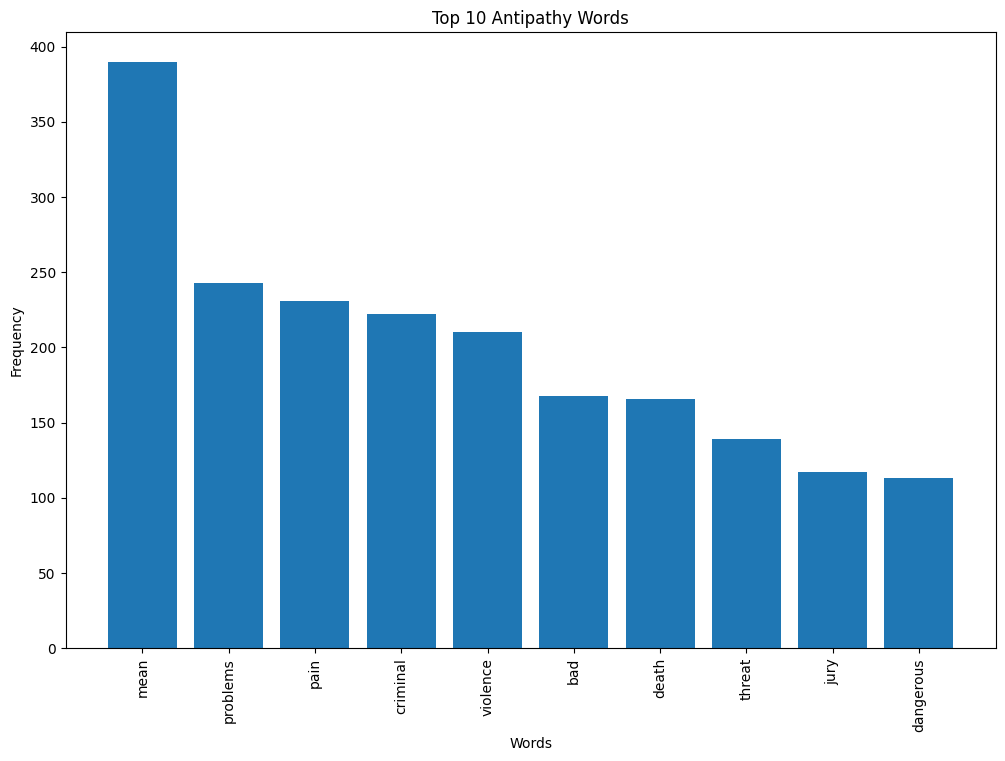

In [9]:
plot_analysis(top_neg_words_MS)

In [27]:
sorted_neg_word_freq_MS['hate']

53

In [10]:
# running the analysis for FOXNEWSW
unigrams_FX, bigrams_FX, sorted_neg_word_freq_FX, top_neg_words_FX = run_analysis('FOXNEWSW', analysis_class)

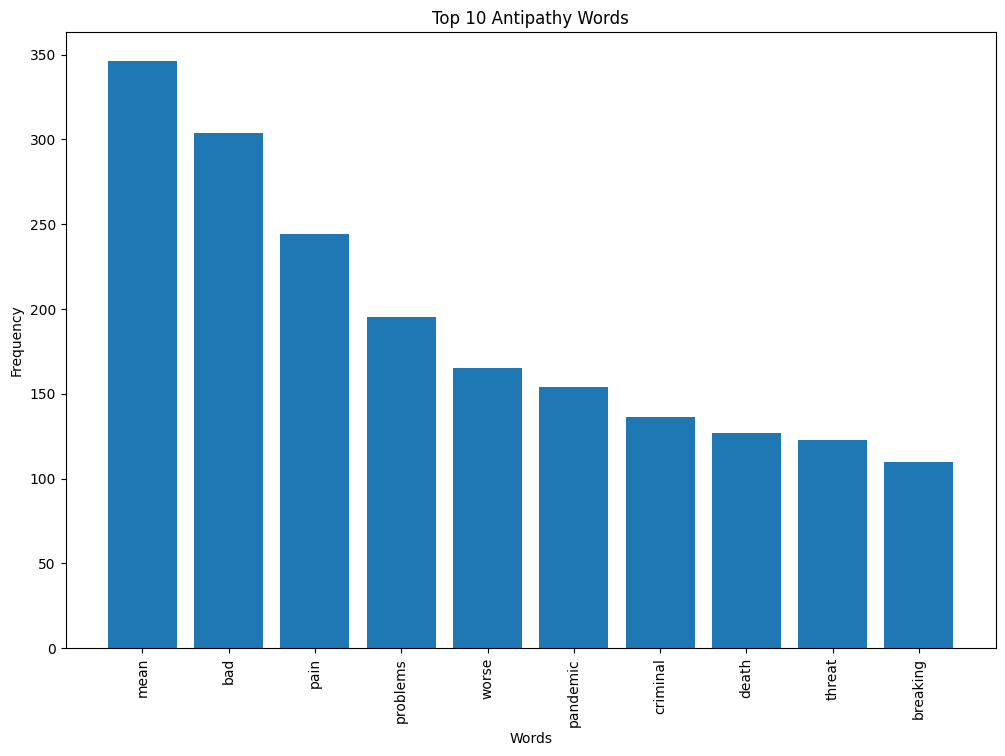

In [11]:
plot_analysis(top_neg_words_FX)

In [28]:
sorted_neg_word_freq_FX['hate']

69

In [12]:
# running the analysis for CNNW
unigrams_CN, bigrams_CN, sorted_neg_word_freq_CN, top_neg_words_CN = run_analysis('CNNW', analysis_class)

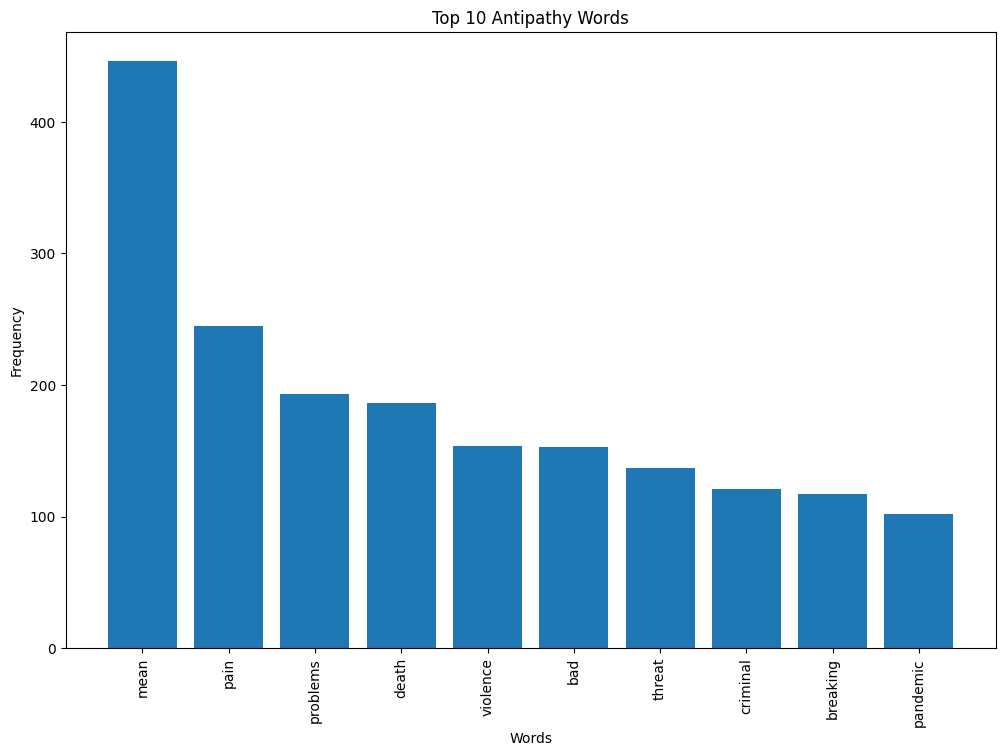

In [13]:
plot_analysis(top_neg_words_CN)

In [29]:
sorted_neg_word_freq_CN['hate']

41

### Context words analysis

In [14]:
def context_word_frequencies(bigrams, target_word):
    before_words = {}
    after_words = {}

    for bigram, frequency in bigrams.items():
        if bigram[0] == target_word:
            after_words[bigram[1]] = after_words.get(bigram[1], 0) + frequency
        elif bigram[1] == target_word:
            before_words[bigram[0]] = before_words.get(bigram[0], 0) + frequency

    sorted_before_words = dict(sorted(before_words.items(), key=lambda item: item[1], reverse=True))
    sorted_after_words = dict(sorted(after_words.items(), key=lambda item: item[1], reverse=True))
    
    size = 10
    if len(sorted_before_words.items()) < 10 or len(sorted_after_words.items()) <10:
        size = min(len(sorted_before_words.items()), len(sorted_after_words.items()))
    
    top_before_words = dict(islice(sorted_before_words.items(), size))
    top_after_words = dict(islice(sorted_after_words.items(), size))
    
    return top_before_words, top_after_words, size

In [15]:
def create_context_word_dataframe(bigrams, target_word):
    before_words, after_words, size = context_word_frequencies(bigrams, target_word)
    context_words = pd.DataFrame(columns=['Before_Words', 'B_Count', 'Target_Word', 
                                          'After_Words', 'A_Count'])
    context_words['Before_Words'] = before_words.keys()
    context_words['B_Count'] = before_words.values()
    context_words['After_Words'] = after_words.keys()
    context_words['A_Count'] = after_words.values()
    context_words['Target_Word'] = [target_word for i in range(size)]
    
    return context_words

In [24]:
context_words_df_MS = create_context_word_dataframe(bigrams_MS, 'hate')
context_words_df_MS

,Before_Words,B_Count,Target_Word,After_Words,A_Count
0,i,15,hate,to,10
1,a,5,hate,crime,10
2,or,3,hate,and,3
3,but,3,hate,managing,3
4,that,2,hate,it,3
5,spread,2,hate,crimes,2
6,federal,2,hate,him,2
7,the,2,hate,speech,2
8,for,2,hate,witch,1
9,savage,1,hate,will,1


In [23]:
context_words_df_FX = create_context_word_dataframe(bigrams_FX, 'hate')
context_words_df_FX

,Before_Words,B_Count,Target_Word,After_Words,A_Count
0,i,14,hate,crime,10
1,you,5,hate,to,10
2,they,5,hate,the,5
3,of,3,hate,speech,4
4,to,3,hate,and,3
5,a,3,hate,on,2
6,federal,3,hate,women,2
7,the,2,hate,it,2
8,asian,2,hate,groups,2
9,and,2,hate,but,1


In [25]:
context_words_df_CN = create_context_word_dataframe(bigrams_CN, 'hate')
context_words_df_CN

,Before_Words,B_Count,Target_Word,After_Words,A_Count
0,i,9,hate,to,5
1,to,4,hate,crimes,4
2,that,3,hate,that,3
3,of,3,hate,he,2
4,by,1,hate,speech,2
5,neonazi,1,hate,the,2
6,prosecute,1,hate,in,2
7,his,1,hate,and,2
8,more,1,hate,crime,2
9,out,1,hate,hes,1
